In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
opj = os.path.join
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from prfpy_csenf.fit import CSenFFitter
from prfpy_csenf.model import CSenFModel
# from prfpy_csenf.rf import *

from dag_prf_utils.prfpy_functions import *
from dag_prf_utils.plot_functions import *

from ncsf_python.utils import *
from ncsf_python.csf_stimuli import * # import stimulus & basic settings...
from ncsf_python.load_saved_info import *
from ncsf_python.plot_functions import *


np.random.seed(0)
'''
We normalized these synthetic voxel time series and added three different noise levels. Noise was generated by sampling from a normal distribution (M = 0, SD = 1) multiplied by a scaling factor 0.4, 0.7, or 1.1.
'''
do_all = True # set to False to only run for 1 ground truth model (speeds up for testing)
g_noise_reps = 100 # number of repetitions for the gaussian noise simulations. Lower for faster
# Add noise to create simulated timecourses
g_noise_levels = {
    'low'   : 0.4,
    'medium': 0.7,
    'high'  : 1.1,
    }

rsq_levels = {
    'high' :  [0.5, 1.0],
    'medium' : [0.3, 0.5],
    'low' : [0.1, 0.3],
    }


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/stimulus.py:252: RuntimeWarning: divide by zero encountered in log10
  self.log_SF_seq = np.log10(self.SF_seq)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/stimulus.py:253: RuntimeWarning: divide by zero encountered in true_divide
  self.CON_S_seq  = 100/self.CON_seq


Number of timepoints: 214
Number of unique SF levels: 6, [ 0.5  1.   3.   6.  12.  18. ]
Number of unique CON levels: 14, [ 0.25   0.39   0.607  0.946  1.475  2.299  3.582  5.583  8.701 13.56
 21.134 32.937 51.332 80.   ]


In [2]:
from figure_finder.figure_saver import FigureSaver
from figure_finder.utils import save_running_code

fig_saver = FigureSaver(
    name='simulation_main-2024-10-04',
    path='/data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/',
    fig_overwrite='ow',   
    save_mode       = True, 
    save_svg        = False,
    save_svg_basic  = True,
    save_png        = True,
    save_pdf        = True,
    folder_ow       = True,

)

save_running_code(opj(fig_saver.path))

FOLDER ALREADY EXISTS!
Deleting and remaking folder


<IPython.core.display.Javascript object>

Notebook not saving...
jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/notebooks/n1_simulation.ipynb --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/simulation_main-2024-10-04/n1_simulation.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/notebooks/n1_simulation.ipynb to html
[NbConvertApp] Writing 1363245 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/simulation_main-2024-10-04/n1_simulation.html


jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/notebooks/n1_simulation.ipynb --no-input --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/simulation_main-2024-10-04/n1_simulation_NOCODE.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/notebooks/n1_simulation.ipynb to html
[NbConvertApp] Writing 1251235 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/simulation_main-2024-10-04/n1_simulation_NOCODE.html


# Set the ground truth parameters

In [3]:
# Same GT parameters as Carlien
GT_params = {
    #                                 GREEN     RED     RED    BLUE
    'width_r'           : np.array([   1.30,   1.00,   1.00,   1.00,]),
    'SFp'               : np.array([   1.00,   2.00,   2.00,   2.00,]),
    'CSp'               : np.array([ 150.00, 100.00, 100.00, 100.00,]),
    'crf_exp'           : np.array([   1.50,   1.50,   1.50,   3.00,]),
    'width_l'           : np.array([   0.68,   0.68,   0.68,   0.68,]),
    'amp_1'             : np.array([   1.00,   1.00,   1.00,   1.00,]),
    'bold_baseline'     : np.array([   0.00,   0.00,   0.00,   0.00,]),
    'hrf_1'             : np.array([   1.00,   1.00,   1.00,   1.00,]),
    'hrf_2'             : np.array([   0.00,   0.00,   0.00,   0.00,]),
    }
edge_type = 'CRF'

csenf_model = CSenFModel(
    stimulus = csenf_stim,
    edge_type=edge_type,
    hrf = [1,1,0]
)

# We want all time series to have a max of 5.0 (arbitrary...)
# -> so we need to cycle through the simulated time series and set the correct amp_1
max_val = 1.0 # 
sim_tc_pre_amp_1_fix = csenf_model.return_prediction(
    width_r = GT_params['width_r'],
    SFp = GT_params['SFp'],
    CSp = GT_params['CSp'],
    width_l = GT_params['width_l'],                          
    crf_exp = GT_params['crf_exp'],
    beta = GT_params['amp_1'],
    baseline = GT_params['bold_baseline'],

    )
for i in range(sim_tc_pre_amp_1_fix.shape[0]):
    # Calculate what the new amp_1 should be
    amp_1 = max_val / np.max(sim_tc_pre_amp_1_fix[i, :])
    # Set the new amp_1
    GT_params['amp_1'][i] = amp_1

# Recalculate the simulated time series with the new amp_1
sim_tc_clean = csenf_model.return_prediction(
    width_r = GT_params['width_r'],
    SFp = GT_params['SFp'],
    CSp = GT_params['CSp'],
    width_l = GT_params['width_l'],                          
    crf_exp = GT_params['crf_exp'],
    beta = GT_params['amp_1'],
    baseline = GT_params['bold_baseline'],
    )
# Check if the max is now 5.0
print(np.max(sim_tc_clean, axis=1))

[1. 1. 1. 1.]


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:272: RuntimeWarning: divide by zero encountered in log10
  log_SF_seq  = np.log10(SF_seq)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:316: RuntimeWarning: divide by zero encountered in true_divide
  cthresh_values = 100/csenf_values


### Add different levels of noise

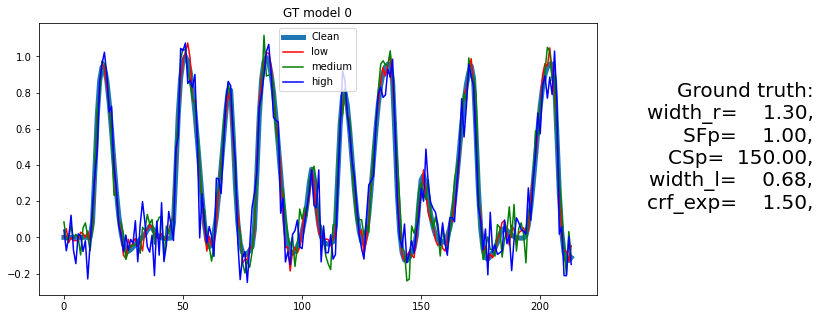

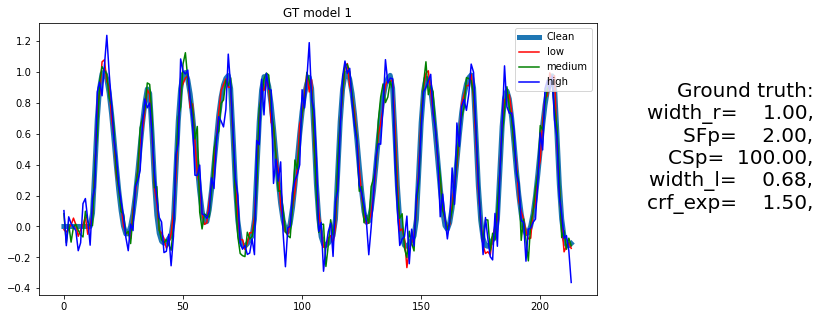

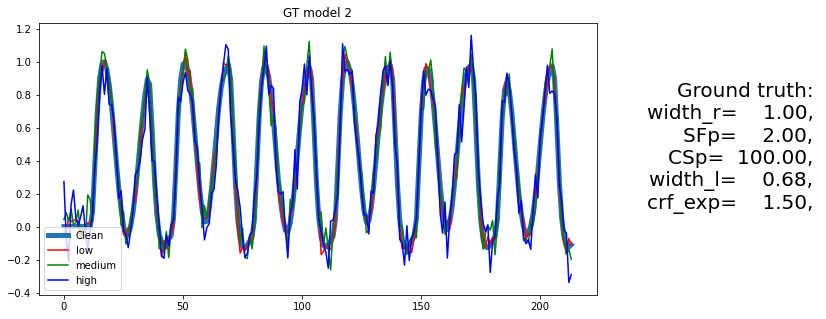

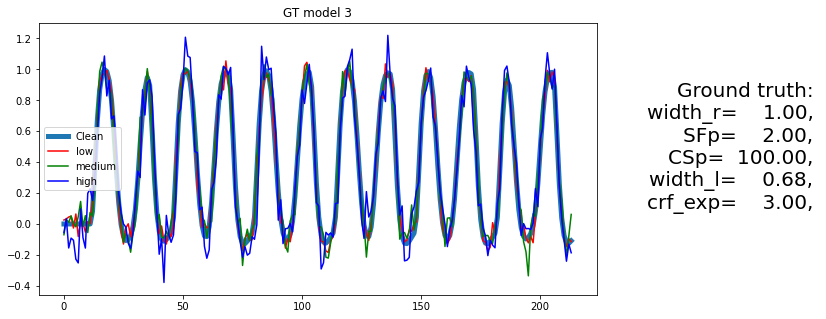

In [4]:
%matplotlib inline
# Clean version
n_timepoints = sim_tc_clean.shape[-1]   # number of timepoints in simulated timecourse
noisy_sim_tc = []                       # list of all the time series
csf_model_index = []                    # list to store index of parameter set for each timecourse
noise_index = []
for g_noise_label,g_noise_value in g_noise_levels.items():
    for i_model in range(GT_params['width_r'].size):
        # g_noise = np.random.normal(0, g_noise_value, (g_noise_reps, n_timepoints))            
        g_noise = np.random.normal(0, 1, (g_noise_reps, n_timepoints)) * g_noise_value
        noisy_sim_tc.append(sim_tc_clean[i_model,:] + g_noise)        
        csf_model_index.append([i_model] * g_noise_reps)
        noise_index.append([g_noise_label] * g_noise_reps)
noisy_sim_tc = np.vstack(noisy_sim_tc)
csf_model_index = np.hstack(csf_model_index)
noise_index = np.hstack(noise_index)


noise_col = ['r', 'g', 'b']
# SANITY CHECKS:
for i_gt in [0,1,2,3]:
    # Plot the clean timecourse
    plt.figure(figsize=(10,5))
    plt.plot(sim_tc_clean[i_gt,:], lw=5, label='Clean')

    for g_noise_id,g_noise_label in enumerate(g_noise_levels.keys()):
        i_noise = np.where(
            (csf_model_index==i_gt) & (noise_index==g_noise_label)
            )[0]
        
        
        plt.plot(
            noisy_sim_tc[i_noise,:].mean(axis=0).T, label=g_noise_label, color=noise_col[g_noise_id])
    
    plt.legend()        
    plt.title(f'GT model {i_gt}')

    gt_txt = 'Ground truth: \n' + \
        f'width_r={GT_params["width_r"][i_gt]:>8.2f}, \n' + \
        f'SFp={GT_params["SFp"][i_gt]:>8.2f}, \n' + \
        f'CSp={GT_params["CSp"][i_gt]:>8.2f}, \n' + \
        f'width_l={GT_params["width_l"][i_gt]:>8.2f}, \n' + \
        f'crf_exp={GT_params["crf_exp"][i_gt]:>8.2f}, \n'
    # Add text to outside right of plot
    # Use monospaced font
    plt.text(
        1.4, 0.5, gt_txt, transform=plt.gca().transAxes, 
        fontsize=20, va='center', ha='right',
        # family='monospace',
        )

### Fit the noisy simulated data

In [5]:
fit_settings = load_yml_settings()
bounds = {
    **fit_settings['csf_bounds'],
    'sfmax'         : [0, 50], 
    'rsq'           : [0, 1],
    'aulcsf'        : [0, 3],
    'ncsf_volume'   : [0, 1],
    'noise_ceil'    : [0, 1],
}
# [2] Setup grids:
# grid_nr = 15 # number of steps in grid
# width_r_grid    = np.linspace(bounds['width_r'][0], bounds['width_r'][1], grid_nr)     
# SFp_grid        = np.linspace(bounds['SFp'][0], bounds['SFp'][1], grid_nr)     
# CSp_grid       = np.linspace(bounds['CSp'][0], bounds['CSp'][1], grid_nr)
# width_l_grid    = np.array(bounds['width_l'][0])
# crf_exp_grid    = np.linspace(bounds['crf_exp'][0], bounds['crf_exp'][1], grid_nr)
mrv_grid = load_mrvista_csf_grid('sub-12112020')
width_r_grid = mrv_grid['width_r']
SFp_grid = mrv_grid['SFp']
CSp_grid = mrv_grid['CSp']
width_l_grid = mrv_grid['width_l']
crf_exp_grid = mrv_grid['crf_exp']

hrf_1_grid = None
hrf_2_grid = None
# -> & grid bounds
csf_grid_bounds = [bounds['amp_1']]

# [3] Setup iterative bounds
bounds_list = [
    (bounds['width_r']),     # width_r
    (bounds['SFp']),     # SFp
    (bounds['CSp']),    # CSp
    (bounds['width_l']),     # width_l
    (bounds['crf_exp']),     # crf_exp
    (bounds['amp_1']),   # amp_1
    (bounds['bold_baseline']),      # baseline
    (bounds['hrf_1']),      # baseline
    (bounds['hrf_2']),      # baseline
]
# -> Constraints determines which scipy fitter is used
csf_constraints = None   # None -> bgfs, [] -> TC


Using the other MRvista PRF file for sub-12112020


In [6]:
# [4] Loop through noise levels and fit simulated data
# Make fitter object
n_jobs = 10
csenf_fitter = CSenFFitter(
    data    = noisy_sim_tc,
    model   = csenf_model,
    n_jobs=n_jobs,
)
# Start grid fit
csenf_fitter.grid_fit(
    width_r_grid    = width_r_grid,
    SFp_grid        = SFp_grid,
    CSp_grid       = CSp_grid,
    width_l_grid    = width_l_grid,
    crf_exp_grid    = crf_exp_grid,
    hrf_1_grid      = hrf_1_grid,
    hrf_2_grid      = hrf_2_grid,
    verbose         = False,
    fixed_grid_baseline=False,
    grid_bounds=csf_grid_bounds, 
    n_batches=n_jobs,
)


# Start iterative fit
csenf_fitter.iterative_fit(
    rsq_threshold = 0.1,            
    verbose = False,
    bounds = bounds_list,
    constraints = csf_constraints,
    xtol=0.0001,   
    ftol=0.0001,           
    )

# # Store recovered parameters in dict
recovered_params = csenf_fitter.iterative_search_params


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/model.py:987: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prediction_params = np.array([width_r,
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:272: RuntimeWarning: divide by zero encountered in log10
  log_SF_seq  = np.log10(SF_seq)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:316: RuntimeWarning: divide by zero encountered in true_divide
  cthresh_values = 100/csenf_values
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimen

# SIMPLIFIED ...

In [7]:
csf_idx_dict = {
    'width_r'       : 0,
    'SFp'           : 1,
    'CSp'          : 2,
    'width_l'       : 3,
    'crf_exp'       : 4,
    'amp_1'         : 5,
    'bold_baseline' : 6,
    'hrf_1'         : 7,
    'hrf_2'         : 8,
    'rsq'           : -1,
}

reco_dict = {}
for p in csf_idx_dict.keys():
    reco_dict[p] = recovered_params[:,csf_idx_dict[p]]
reco_pd = pd.DataFrame(reco_dict)
GT_pd = pd.DataFrame(GT_params)

rsq_masks = {}
for rsq_label, rsq_val in rsq_levels.items():
    # rsq_masks[rsq_label] = (reco_obj.pd_params['rsq'] > rsq_val[0]) & (reco_obj.pd_params['rsq'] <= rsq_val[1])
    rsq_masks[rsq_label] = (reco_pd['rsq'] > rsq_val[0]) & (reco_pd['rsq'] <= rsq_val[1])
    rsq_masks[rsq_label] = rsq_masks[rsq_label].to_numpy()



In [8]:
reco_obj = CSenFPlotter(
    prf_params=reco_dict,
    real_ts = noisy_sim_tc, 
    prfpy_model = csenf_model,
)
GT_obj = CSenFPlotter(
    prf_params=GT_params,
    real_ts = sim_tc_clean, 
    prfpy_model = csenf_model,
)


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:180: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_SFp'] = np.log10(self.params_dd['SFp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:181: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_CSp'] = np.log10(self.params_dd['CSp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:182: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_crf_exp'] = np.log10(self.params_dd['crf_exp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:40: RuntimeWarning: divide by zero encountered in log10
  log10_CSp = np.log10(CSp)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:41: RuntimeWarning: divid

## P1 - nCSF curves only now

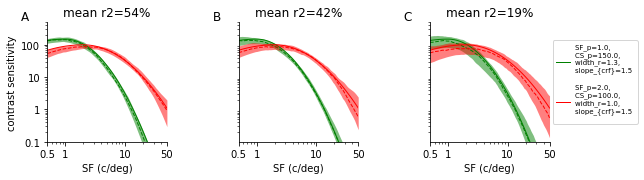

In [9]:
ncsf_gt_col = {
    0 : 'green',
    1 : 'red',
    2 : 'red', # cyan, changed following reviewer 3
    3 : 'blue',

}

n_row = 1
n_col = 3
fig, axs = plt.subplots(
    n_row, n_col,
    figsize=(9,6)
)
# fig.set_tight_layout(True)
# Adding subfigure labels (A, B, C, etc.)

for iP in range(n_col):
    label = string.ascii_uppercase[0 * n_col + iP]  # A, B, C, ...
    axs[iP].text(-0.15, 1.1, label, transform=axs[iP].transAxes,
                        fontsize=12, va='top', ha='right')

# - make sure it doesn't overlap with the plots
# fig.subplots_adjust(top=0.85)
# [1] nCSF plots
for i_gt in [0,1]:
    gt_index = csf_model_index==i_gt
    for i_ax,rsq_id in enumerate(rsq_levels.keys()):
        gt_rsq_index = rsq_masks[rsq_id] & gt_index

        
        # *********** Plot recovered CSF curves *********** 
        # *************************************************
        # Setup the axis
        ax = axs[i_ax]
        # PLOT GROUND TRUTH ****
        this_label = f'SF_p={GT_params["SFp"][i_gt]:>.1f}, \n' + \
            f'CS_p={GT_params["CSp"][i_gt]:>.1f}, \n' + \
            f'width_r={GT_params["width_r"][i_gt]:>.1f}, \n' + \
            'slope_{crf}' + f'={GT_params["crf_exp"][i_gt]:>.1f} \n'  
        
        this_params = GT_obj.pd_params.iloc[i_gt]
        ncsfplt_csf_curve(
            params=this_params,
            # csf_obj=GT_obj,            
            # idx=i_gt, 
            ax=ax,
            line_col=ncsf_gt_col[i_gt],
            linewidth=2, 
            line_label=this_label,         
            add_extrapolated=False,    
        )

        # PLOT RECOVERED PARAMETERS
        this_params = reco_obj.pd_params.iloc[gt_rsq_index]
        ncsfplt_csf_curve(
            params=this_params,
            # csf_obj=reco_obj,
            # idx=gt_rsq_index,
            ax=ax,
            line_col=ncsf_gt_col[i_gt],
            label='_',     
            add_extrapolated=False,   
            line_kwargs = {'linestyle':'--'},
        )
        
        
        m_rsq = np.mean(reco_pd['rsq'][rsq_masks[rsq_id]])
        # print(m_rsq)
        ax.set_title(f'mean r2={m_rsq*100:.0f}%')
        if i_ax!=0:
            ax.set_ylabel('')
            ax.set_yticks([])
        if (i_ax==2):
            ax.legend(
                fontsize=7, loc='center left', 
                bbox_to_anchor=(1,0.5), 
                )
fig.subplots_adjust(
    hspace=0.8,
    wspace=0.6,
    )      

fig_saver.add_img(fig, fig_name='simnoise_MAIN_csf')


# Boxplots full Main

0, col=green, true val aulcsf = 74.6374
0, col=green, true val SFp = 1.0000
0, col=green, true val CSp = 150.0000
1, col=red, true val aulcsf = 91.2839
1, col=red, true val SFp = 2.0000
1, col=red, true val CSp = 100.0000


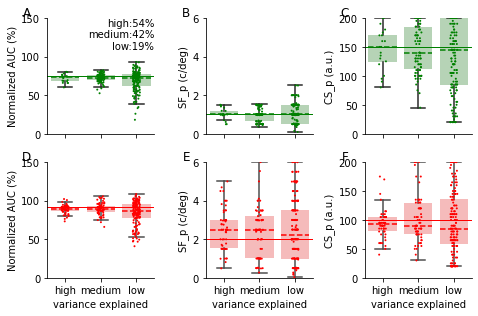

In [10]:
gt2plot = [0 , 1]
p2plot = ['aulcsf', 'SFp', 'CSp', ]
fig, axs = plt.subplots(
    2, len(p2plot),
    figsize=(6.75, 4.5),
)

do_crf_log = True
fig.set_tight_layout(True)
plt.subplots_adjust(hspace=0.5)
p2plot_nice = {
    'sfmax': 'SF_{max} (c/deg)',
    'aulcsf': 'Normalized AUC (%)',
    'SFp': 'SF_p (c/deg)',
    'CSp': 'CS_p (a.u.)',
    'crf_exp': 'slope_{crf} (a.u.)',
    'width_r': 'width_r (a.u.)',
}

# Adding subfigure labels (A, B, C, etc.)
for i_row in range(2):
    for iP in range(len(p2plot)):
        label = string.ascii_uppercase[i_row * len(p2plot) + iP]  # A, B, C, ...
        axs[i_row, iP].text(-0.15, 1.1, label, transform=axs[i_row, iP].transAxes,
                            fontsize=12, va='top', ha='right')

for i_row, i_gt in enumerate(gt2plot):
    gt_index = csf_model_index == i_gt
    # ***************************************************************************************************************
    # ****************************************** SWARM PLOTS ********************************************************    
    # Make mrsq labels
    mrsq_labels = ''
    for level in ['high', 'medium', 'low']:
        mrsq = np.mean(reco_pd['rsq'][rsq_masks[level]]) # .to_numpy()
        mrsq_labels += f'{level}:{mrsq*100:.0f}%\n'
        


    sw_ax = axs[i_row]
    # Loop through ps for swarm plot
    for iP,param in enumerate(p2plot):    
        if (i_row==0) & (iP==0):
            # Add mean rsq by level info
            sw_ax[iP].text(1, 1, mrsq_labels, transform=sw_ax[iP].transAxes, ha='right', va='top')

        # sns.swarm plot of {param}, split by noise level. Colors of each level determined by g_noise_cols
        # -> with labels on x-axis
        # -> make data frame for data
        data = {
            'rsq_id' : [],
            'param'  : [],
        }
        for rsq_id in rsq_levels.keys():
            gt_rsq_index = rsq_masks[rsq_id] & gt_index
            
            data['rsq_id'] += [rsq_id] * np.sum(gt_rsq_index)
            data['param'] += reco_obj.pd_params[param][gt_rsq_index].tolist()

        data = pd.DataFrame(data)
        # Strip plot, with colors determined by noise_cols
        sns.stripplot(
            data = data,
            ax = sw_ax[iP],
            color = ncsf_gt_col[i_gt],
            x = 'rsq_id',
            y = 'param',
            size=2,
            )
        
        # Also sns boxplot, displaying same data as in the swarmplot
        # -> but a little bit transparent
        sns.boxplot(
            data = data,
            ax = sw_ax[iP],
            color = ncsf_gt_col[i_gt],
            boxprops=dict(alpha=.3, linewidth=0),
            medianprops=dict(color=ncsf_gt_col[i_gt], linestyle='dashed'),
            showfliers=False,
            x = 'rsq_id',
            y = 'param',
            
            
            )
        # Set ylim to bounds of parameter
        sw_ax[iP].set_ylim(bounds[param])
        if param=='sfmax':
            sw_ax[iP].set_ylim(0, 100)
        elif param=='aulcsf':
            sw_ax[iP].set_ylim(0, 150)
            
        if do_crf_log & (param=='crf_exp'):
            sw_ax[iP].set_ylim([0.1, 10])
            sw_ax[iP].set_yscale('log')
            sw_ax[iP].set_yticks([0.1, 1, 10])
            sw_ax[iP].set_yticklabels(['0.1', '1', '10'])

        sw_ax[iP].set_xlabel(f'')        
        sw_ax[iP].set_ylabel(p2plot_nice[param])
        sw_ax[iP].axhline(
            GT_obj.pd_params[param][i_gt], 
            color = ncsf_gt_col[i_gt],
            lw=1,
            )
        print(f'{i_gt}, col={ncsf_gt_col[i_gt]}, true val {param} = {GT_obj.pd_params[param][i_gt]:.4f}')
        if i_row==0:
            sw_ax[iP].set_xticklabels('')
        else:
            sw_ax[iP].set_xticklabels(['high', 'medium', 'low'])
            sw_ax[iP].set_xlabel('variance explained')
        
        sw_ax[iP].spines['right'].set_visible(False)
        sw_ax[iP].spines['top'].set_visible(False)
        sns.despine()

fig_saver.add_img(plt.gcf(), fig_name='simnoise_MAIN_swarm',)


# For supplement: CRF

## CRF curves

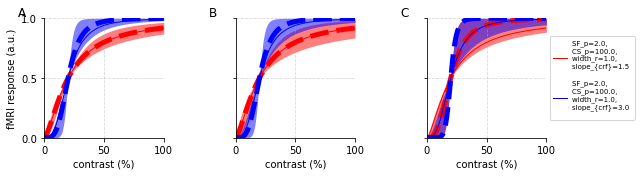

In [14]:
ncsf_gt_col = {
    0 : 'green',
    1 : 'red',
    2 : 'red',
    3 : 'blue',

}

CRF_kwargs = {
    'ow_Qs' : True,
    'sf_for_crf' : None,
    'do_log' : False,
    'Qs_at_CSp' : False,
}
n_row = 1
n_col = 3
fig, axs = plt.subplots(
    n_row, n_col,
    figsize=(9,3)
)
# fig.set_tight_layout(True)
# Adding subfigure labels (A, B, C, etc.)

for iP in range(n_col):
    label = string.ascii_uppercase[0 * n_col + iP]  # A, B, C, ...
    axs[iP].text(-0.15, 1.1, label, transform=axs[iP].transAxes,
                        fontsize=12, va='top', ha='right')


# [1] nCSF plots
for i_gt in [2,3]:
    gt_index = csf_model_index==i_gt
    for i_ax,rsq_id in enumerate(rsq_levels.keys()):
        gt_rsq_index = rsq_masks[rsq_id] & gt_index

        # *********** Plot recovered CRF curves *********** 
        # *************************************************
        contrast_pc = np.linspace(0, 100, 100)        
        # Setup the axis
        ax = axs[i_ax]

        this_label = '' + \
            f'SF_p={GT_params["SFp"][i_gt]:>.1f}, \n' + \
            f'CS_p={GT_params["CSp"][i_gt]:>.1f}, \n' + \
            f'width_r={GT_params["width_r"][i_gt]:>.1f}, \n' + \
            'slope_{crf}' + f'={GT_params["crf_exp"][i_gt]:>.1f} \n'  

        this_params = GT_obj.pd_params.iloc[i_gt]
        ncsfplt_crf_curve(
            params=this_params,
            # csf_obj=GT_obj,
            # idx=i_gt, 
            ax=ax,
            line_col=ncsf_gt_col[i_gt],
            linewidth=1.5, 
            line_label=this_label,
            **CRF_kwargs            

        )
        # ***

        # PLOT RECOVERED PARAMETERS
        this_params = reco_obj.pd_params.iloc[gt_rsq_index]
        ncsfplt_crf_curve(
            params=this_params,
            # csf_obj=reco_obj,
            # idx=gt_rsq_index, 
            ax=ax,
            line_col=ncsf_gt_col[i_gt],
            line_label='_',     
            lw = 5, 
            line_kwargs = {'linestyle':'--'},      
            **CRF_kwargs                        
        )        
        if i_ax!=0:
            ax.set_ylabel('')
            ax.set_yticklabels(['','',''])
        if (i_ax==2):
            ax.legend(
                fontsize=7, loc='center left', 
                bbox_to_anchor=(1,0.5), 
                )
            # ax.legend() #loc='center left', bbox_to_anchor=(1,0.5), ) #justify=(1,0))        

fig.subplots_adjust(
    hspace=0.8,
    wspace=0.6,
    )      

fig_saver.add_img(fig, fig_name='simnoise_SUP_crf')


## Boxplot

2, col=red, true val crf_exp = 1.5000
3, col=blue, true val crf_exp = 3.0000


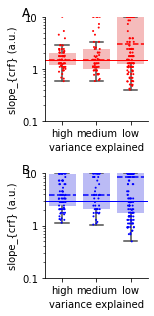

In [15]:
gt2plot = [2 , 3]
p2plot = ['crf_exp']
param = 'crf_exp'
fig, axs = plt.subplots(
    2, len(p2plot),
    figsize=(2.25, 4.5),
)

do_crf_log = True
fig.set_tight_layout(True)
plt.subplots_adjust(hspace=0.5)
p2plot_nice = {
    'sfmax': 'SF_{max} (c/deg)',
    'aulcsf': 'Normalized AUC (%)',
    'SFp': 'SF_p (c/deg)',
    'CSp': 'CS_p (a.u.)',
    'crf_exp': 'slope_{crf} (a.u.)',
    'width_r': 'width_r (a.u.)',
}

# Adding subfigure labels (A, B, C, etc.)
for i_row in range(2):
    label = string.ascii_uppercase[i_row]  # A, B, C, ...
    axs[i_row].text(-0.15, 1.1, label, transform=axs[i_row].transAxes,
                        fontsize=12, va='top', ha='right')
# Make mrsq labels
mrsq_labels = ''
for level in ['high', 'medium', 'low']:
    mrsq = np.mean(reco_pd['rsq'][rsq_masks[level]]) # .to_numpy()
    mrsq_labels += f'{level}:{mrsq*100:.0f}%\n'
    
# Add mean rsq by level info
if i_row==0:
    axs[0].text(1, 1, mrsq_labels, transform=axs[0].transAxes, ha='right', va='top')
sw_ax = axs    
for iP, i_gt in enumerate(gt2plot):
    gt_index = csf_model_index == i_gt

    # sns.swarm plot of {param}, split by noise level. Colors of each level determined by g_noise_cols
    # -> with labels on x-axis
    # -> make data frame for data
    data = {
        'rsq_id' : [],
        'param'  : [],
    }
    for rsq_id in rsq_levels.keys():
        gt_rsq_index = rsq_masks[rsq_id] & gt_index
        
        data['rsq_id'] += [rsq_id] * np.sum(gt_rsq_index)
        data['param'] += reco_obj.pd_params[param][gt_rsq_index].tolist()

    data = pd.DataFrame(data)
    # Strip plot, with colors determined by noise_cols
    sns.stripplot(
        data = data,
        ax = sw_ax[iP],
        color = ncsf_gt_col[i_gt],
        x = 'rsq_id',
        y = 'param',
        size=2,
        )
        
    # Also sns boxplot, displaying same data as in the swarmplot
    # -> but a little bit transparent
    sns.boxplot(
        data = data,
        ax = sw_ax[iP],
        color = ncsf_gt_col[i_gt],
        boxprops=dict(alpha=.3, linewidth=0),
        medianprops=dict(color=ncsf_gt_col[i_gt], linestyle='dashed'),
        showfliers=False,
        x = 'rsq_id',
        y = 'param',        
        
        )
    # Set ylim to bounds of parameter
    sw_ax[iP].set_ylim(bounds[param])

        
    if do_crf_log & (param=='crf_exp'):
        sw_ax[iP].set_ylim([0.1, 10])
        sw_ax[iP].set_yscale('log')
        sw_ax[iP].set_yticks([0.1, 1, 10])
        sw_ax[iP].set_yticklabels(['0.1', '1', '10'])

    sw_ax[iP].set_xlabel(f'')        
    sw_ax[iP].set_ylabel(p2plot_nice[param])
    sw_ax[iP].axhline(
        GT_obj.pd_params[param][i_gt], 
        color = ncsf_gt_col[i_gt],
        lw=1,
        )
    print(f'{i_gt}, col={ncsf_gt_col[i_gt]}, true val {param} = {GT_obj.pd_params[param][i_gt]:.4f}')
    if i_row==0:
        sw_ax[iP].set_xticklabels('')
    else:
        sw_ax[iP].set_xticklabels(['high', 'medium', 'low'])
        sw_ax[iP].set_xlabel('variance explained')
    
    sw_ax[iP].spines['right'].set_visible(False)
    sw_ax[iP].spines['top'].set_visible(False)
    sns.despine()

fig_saver.add_img(plt.gcf(), fig_name='simnoise_SUP_swarm',)


# save

In [13]:
save_running_code(opj(fig_saver.path))

<IPython.core.display.Javascript object>

Notebook not saving...
jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/notebooks/n1_simulation.ipynb --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/simulation_main-2024-10-04/n1_simulation.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/notebooks/n1_simulation.ipynb to html
[NbConvertApp] Writing 1363245 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/simulation_main-2024-10-04/n1_simulation.html


jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/notebooks/n1_simulation.ipynb --no-input --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/simulation_main-2024-10-04/n1_simulation_NOCODE.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/notebooks/n1_simulation.ipynb to html
[NbConvertApp] Writing 1251235 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/notebook_timeline/simulation_main-2024-10-04/n1_simulation_NOCODE.html
